In [1]:
import math
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import random
from random import randint

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image


from IPython.display import Image
from IPython.core.display import Image, display

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as FT


from PIL import Image
import matplotlib.pyplot as plt

from file_manipulations import getSortedFramePaths
from vae_conv import VariationalAutoencoder, Encoder, Decoder

In [2]:
device = torch.device("cuda")

In [3]:
vae = VariationalAutoencoder().to(device)
vae.load_state_dict(torch.load('vae_conv.pth'))
vae.eval()

VariationalAutoencoder(
  (encoder): Encoder(
    (conv_1): Conv2d(1, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_2): Conv2d(2, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_3): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_4): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc_mu): Linear(in_features=512, out_features=256, bias=True)
    (fc_logvar): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (conv_trans_1): ConvTranspose2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_trans_2): ConvTranspose2d(4, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_trans_3): ConvTranspose2d(2, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (linear): Linear(in_features=256, out_features=512, bias=True)
    (sigmoid): Sigmoid()
  )
)

In [4]:
seq_len_x = 5
seq_len_y = 20
batch_size = 32
image_size = 64

In [5]:
image_path = "./Dance Data/SkeletonDataClean/Skeleton/Basic/"
composed_transform = torchvision.transforms.Compose([transforms.Resize(image_size), transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

class DanceFrameDataset(Dataset):
    def __init__(self, image_path, transforms, seq_len_x, seq_len_y):
        self.transforms = transforms
        self.image_path = image_path
        self.seq_len_x = seq_len_x
        self.seq_len_y = seq_len_y
        self.image_names = getSortedFramePaths(self.image_path, ['gBR', 'gHO', 'gLH','gWA'])
    def __len__ (self):
            return len(self.image_names) - self.seq_len_x - self.seq_len_y
    def __getitem__(self, idx):
        image_locations = self.image_names[idx:idx+self.seq_len_x+self.seq_len_y]
        images = torch.empty(self.seq_len_x+self.seq_len_y, 256)
        i = 0
        with torch.no_grad():
            for image_location in image_locations:
                x = (self.transforms(Image.open(image_location)) > 0.5).float().view(1, 1, 64, 64)
                images[i] = vae.encoder(x.to(device))[0]
                i += 1
        

        return images[0:self.seq_len_x], images[self.seq_len_x:self.seq_len_x+self.seq_len_y]
    
frame_dataset = DanceFrameDataset(image_path, composed_transform, seq_len_x, seq_len_y)
frame_loader = DataLoader(dataset=frame_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [6]:
len(frame_loader)

1941

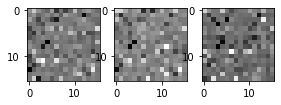

In [7]:
idx = 0

frames_x, frames_y = next(iter(frame_loader))
frames_x_dec = frames_y.to(device)
frames_x_dec = vae.decoder(frames_x_dec[idx])

for i in range(3):
    plt.subplot(1, 4, i+1)
    plt.imshow(frames_y[0][i].view(16, 16), cmap="gray")

In [8]:
frames_x.shape

torch.Size([32, 5, 256])

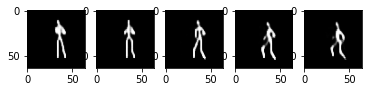

In [9]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(frames_x_dec[i].detach().cpu().view(64, 64), cmap="gray")

In [10]:
class Encoder(nn.Module):
    def __init__(self, num_features, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.dropout = nn.Dropout(p)
        
        self.rnn = nn.LSTM(num_features, hidden_size, num_layers, dropout=p, batch_first=True)
        
    def forward(self, x):
        # (seq_len, batch_size)
        
        outputs, (hidden, cell) = self.rnn(x)        
        
        return hidden, cell
        

In [11]:
class Decoder(nn.Module):
    def __init__ (self, num_features, hidden_size, num_layers, p):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.dropout = nn.Dropout(p)
        self.rnn = nn.LSTM(num_features, hidden_size, num_layers, dropout=p, batch_first=True)
        self.fc =  nn.Linear(hidden_size, num_features)
        
    def forward(self, x, hidden, cell):
        predictions, (hidden, cell) = self.rnn(x, (hidden, cell))

        predictions = self.fc(predictions)

        return predictions, hidden, cell

In [12]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, source, target, teacher_force_ratio, validation):
        batch_size = source.shape[0]
        target_len = seq_len_y
        
        
        hidden, cell = self.encoder(source)
        
        x = source[:, -1, :].unsqueeze(1)
        
        for t in range(target_len):
            output, hidden, cell= self.decoder(x, hidden, cell)
            
            if 'outputs' in locals():
                outputs = torch.cat((outputs, output), dim=1)
            else:
                outputs = output
            
            if validation == True:
                x = output
            else:
                x = target[:, t, :].unsqueeze(1) if random.random() < teacher_force_ratio else output
                
        return outputs

In [19]:
num_epochs = 100
learning_rate = 0.001

num_features = 256
hidden_size = 2048
num_layers = 2
dropout = 0.8

loss_hist = []

In [20]:
encoder_net = Encoder(num_features, hidden_size, num_layers, dropout).to(device)
decoder_net = Decoder(num_features, hidden_size, num_layers, dropout).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)

In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)

In [23]:
load_model = False

def save_checkpoint (state, file_name="seq2seq-teach-p2.pth.tar"):
    print('Saving Checkpoint')
    torch.save(state, file_name)
def load_checkpoint (checkpoint):
    print('Loading Checkpoint')
    model.load_state_dict(checkpoint['state_dict'])

if load_model:
    load_checkpoint(torch.load('seq2seq-teach.pth.tar'))

In [ ]:
for epoch in range(num_epochs):
    checkpoint = {'state_dict': model.state_dict()}
    save_checkpoint(checkpoint)
    for idx, (source, target) in enumerate(frame_loader):
        optimizer.zero_grad()
        
        source, target = source.to(device), target.to(device)
        
        output = model(source, target, 0.15, False)
        
        loss1 = criterion(output[:, 0, :], target[:, 0, :])
        
        loss2 = criterion(output[:, 5, :], target[:, 5, :])
        
        loss3 = criterion(output[:, 10, :], target[:, 10, :])
        
        loss1 = criterion(output[:, 15, :], target[:, 15, :])
        
        loss4 = criterion(output[:, -1, :], target[:, -1, :])
        
        loss = loss1 + loss2 + loss3 + loss4

        loss_hist.append(loss.item())

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()
    
    
        if idx % 100 == 0:
            print(f'Epoch: {epoch} / {num_epochs} Batch:: {idx}/{len(frame_loader)} Loss: {loss}')
    mean_loss = sum(loss_hist)/len(loss_hist)
    scheduler.step(mean_loss)

In [ ]:
target.shape

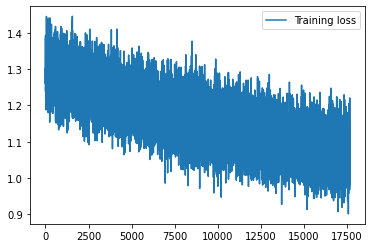

In [25]:
plt.plot(loss_hist, label="Training loss")
plt.legend()
plt.show()

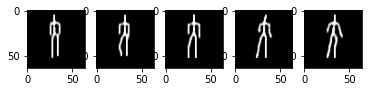

In [26]:
with torch.no_grad():
    img = vae.decoder(torch.squeeze(target[8])).detach().cpu()
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(img[i].view(64, 64), cmap="gray")

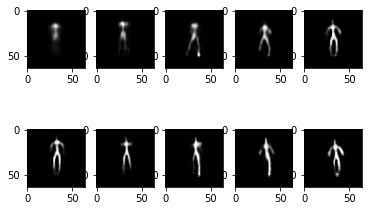

In [27]:
with torch.no_grad():
    img = vae.decoder(torch.squeeze(output[8])).detach().cpu()
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(img[i].view(64, 64), cmap="gray")

In [38]:
torch.save(model.state_dict(), 'seq2seq-teach-2.pth')

In [39]:
img_x = vae.decoder(torch.squeeze(source[8])).detach().cpu()

for i in range(seq_len_x):
    image = img_x[i]
    image = FT.to_pil_image(image)
    image.save(f'generated/seq2seq/{i}.png')

In [28]:
for i in range(seq_len_y):
    image = img_pred[i]
    image = FT.to_pil_image(image)
    image.save(f'generated/seq2seq/y_{20+i}.png')

In [32]:
import cv2
import numpy as np
import glob
import os
from os.path import isfile, join
import re

def Images2Video (pathIn, pathOut, frameSize):

    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
    files.sort(key=lambda f: int(re.sub('\D', '', f)))

    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), 20, frameSize)
    print(files)
    for filename in files:
        img = cv2.imread(pathIn + filename)
        out.write(img)

    out.release()

In [30]:
Images2Video('generated/seq2seq/', 'generated/seq2seq/output.avi', (64, 64))

['0.png', '1.png', '2.png', '3.png', '4.png', 'y_20.png', 'y_21.png', 'y_22.png', 'y_23.png', 'y_24.png', 'y_25.png', 'y_26.png', 'y_27.png', 'y_28.png', 'y_29.png', 'y_30.png', 'y_31.png', 'y_32.png', 'y_33.png', 'y_34.png', 'y_35.png', 'y_36.png', 'y_37.png', 'y_38.png', 'y_39.png']
